In [65]:
import os
import sys
import random
import numpy as np
from IPython.display import clear_output
from matplotlib.pyplot import imshow, figure, show

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [79]:
model = load_model("./saved_model/mushie_mobilenet_finetuned.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

### Image Data
First, choose an image to run through the XAI system. Then, the cells below will use each XAI method below to highlight explanatory features.

In [18]:
path = "../../Google Drive/My Drive/498/Project/mushie_image_data/"

Cortinariusrubellus38_gimages.jpg


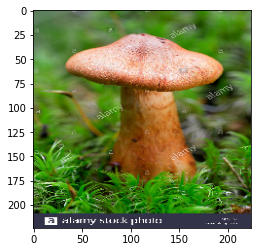

In [86]:
# Choose a random photo from the poisonous folder
mushie_class = "poisonous"
files = os.listdir(path + mushie_class)
d = random.choice(files)
file_path = path + mushie_class + "/" + d

img = load_img(file_path, target_size=(224, 224))
img = img_to_array(img)
img_data = ([img], None)

imshow(img/255.)
print(d)

Lactariusmammosus111_gimages.jpg


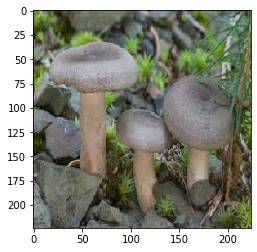

In [89]:
# Or Choose a random photo from the edible folder
mushie_class = "edible"
files = os.listdir(path + mushie_class)
d = random.choice(files)
file_path = path + mushie_class + "/" + d

img = load_img(file_path, target_size=(224, 224))
img = img_to_array(img)
img_data = ([img], None)

imshow(img/255.)
print(d)

### TF-Explain comparison tool
[TF-Explain](https://tf-explain.readthedocs.io/en/latest/) is a Python library that combines several XAI methods under a unified API. The methods we'll be comparing here are:
* [GradCAM](https://github.com/sicara/tf-explain#grad-cam): Visualize how parts of the image affects neural network's output by looking into the activation maps.
* [Integrated Gradients](https://github.com/sicara/tf-explain#integrated-gradients): Visualize an average of the gradients along the construction of the input towards the decision.
* [Occlusion Sensitivity](https://github.com/sicara/tf-explain#occlusion-sensitivity): Visualize how parts of the image affects neural network's confidence by occluding parts iteratively
* [SmoothGrad](https://github.com/sicara/tf-explain#smoothgrad): Visualize stabilized gradients on the inputs towards the decision

In [83]:
# Get all the explainer objects into a list so we can loop over them
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.smoothgrad import SmoothGrad

explainer_list = []
explainer_list.append((GradCAM(), "GradCAM"))
explainer_list.append((IntegratedGradients(), "Integrated Gradients"))
explainer_list.append((OcclusionSensitivity(), "Occlusion Sensitivity"))
explainer_list.append((SmoothGrad(), "SmoothGrad"))

Lactariusmammosus111_gimages.jpg


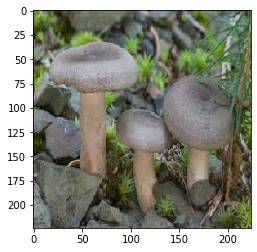

GradCAM


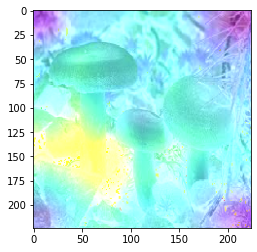

Integrated Gradients


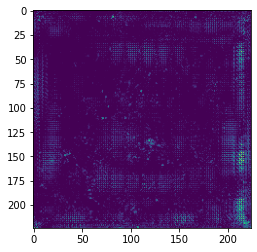

Occlusion Sensitivity


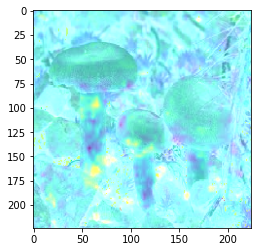

SmoothGrad


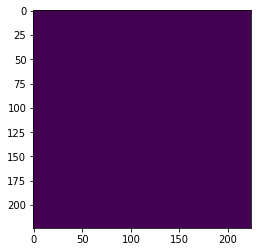

In [91]:
# Let's see the image we want to get a reading on (again)
print(d)
imshow(img/255.)
show()

# Then loop through all the explainability methods to compare side-by-side
for explainer, name in explainer_list:
    print(name)
    if name == "Occlusion Sensitivity":
        output = explainer.explain(img_data, model, class_index=0, patch_size=4)
    else:
        output = explainer.explain(img_data, model, class_index=0)
    imshow(output)
    show()

In [30]:
explainer.save(output, ".", "test.png")